In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import data, img_as_float

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
import skimage.transform as trans

import shutil
import itertools
from datetime import datetime

import rasterio

In [2]:
import sys
sys.path.append(r"..")

import phenocamomatic

### Outside of this notebook we extracted a chunk of landsat to use as a managable reference grid

In [10]:
basedir = r"J:\Projects\NCCSC\phenocam\DerivedData\harvard"
landsat_subset_fname = os.path.join(basedir, "Landsat", "Subset", "subset.tif")
landsat = rasterio.open(landsat_subset_fname)
landsat_data = landsat.read()

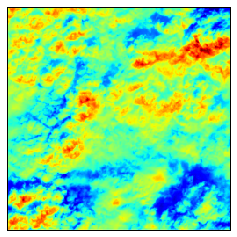

In [11]:
%matplotlib inline
plt.imshow(landsat_data[0,:,:], interpolation='none')
phenocamomatic.plotting.format_photo_axes(plt.gca())

## This was overlaid on our ArcScene photo recreation and converted to a couple of grid representations

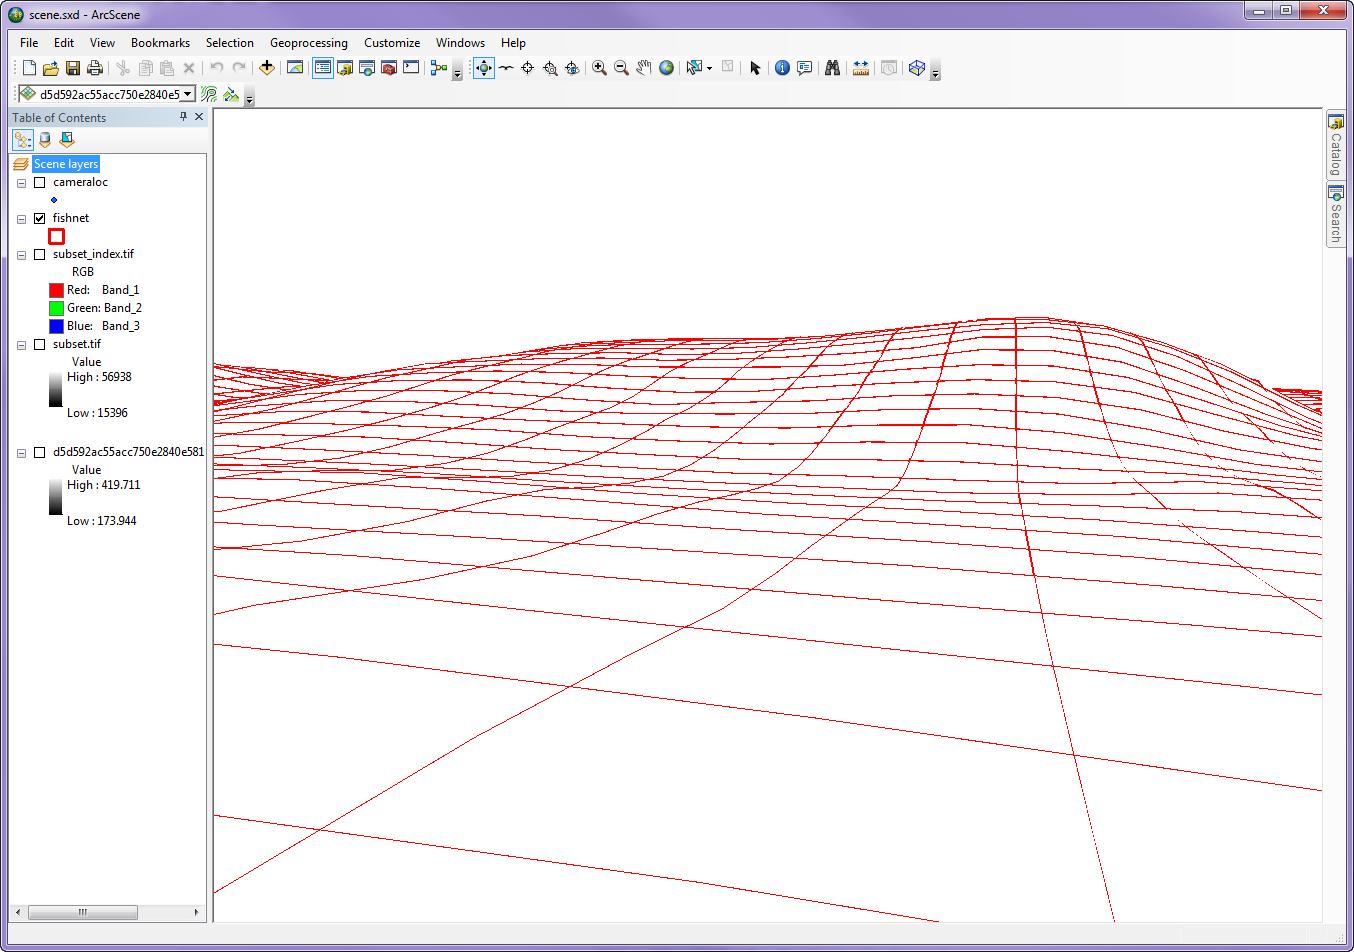

In [7]:
from IPython.display import Image
Image(filename=r"J:\Projects\NCCSC\phenocam\DerivedData\harvard\ArcScene\ScreneGrab.png")

### Which are then exported as flat images for use in the rest of this notebook

In [12]:
ls_red_grid_fname = os.path.join(basedir, "ArcScene", "red_gridlines.bmp")
ls_grid_index_fname = os.path.join(basedir, "ArcScene", "IndexGrid.bmp")

quickbird = phenocamomatic.dataaccess.get_site('harvard')
which_img = -197


Extracted exposure:  193


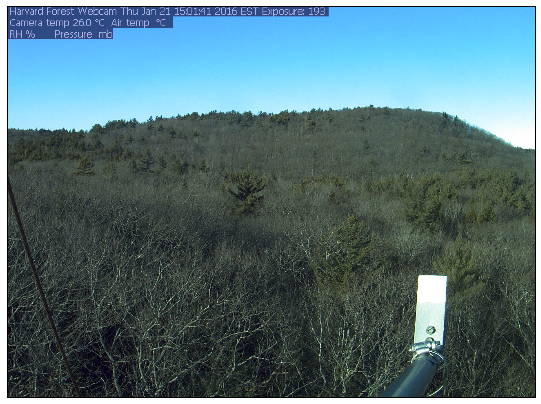

In [13]:
%matplotlib inline
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
# local_fname = quickbird.get_local_image_fname(quickbird.midday_fnames[which_img])
local_fname = r"J:\Projects\NCCSC\phenocam\DerivedData\harvard\ArcScene\InputData\harvard_2016_01_21_150140.jpg"
# print local_fname
# sample_image = quickbird.get_local_image(quickbird.midday_fnames[which_img])
sample_image = quickbird.get_local_image(local_fname)
ax.imshow(sample_image)

# phenocamomatic.plotting.add_rois(ax, quickbird, vistype='line', lw=7, alpha=0.9)
# 
phenocamomatic.plotting.format_photo_axes(ax)
# plt.legend(loc=1)

exposure = phenocamomatic.headerextraction.get_exposure(local_fname)
print "Extracted exposure: ", exposure

### Our landsat grid image create in ArcScene

In [14]:
data_grid = skimage.io.imread(ls_red_grid_fname)


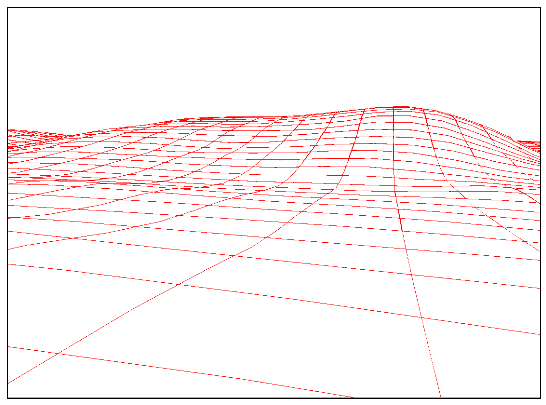

In [15]:
plt.figure(figsize=(10, 7))
plt.imshow(data_grid)
phenocamomatic.plotting.format_photo_axes(plt.gca())

### But how do these align?

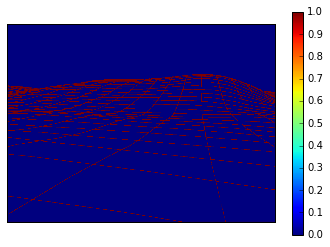

In [16]:
# While approximatly equal in aspect we need to reshape our grid overlay
#to match the dimensions of our photos
data_trans = trans.resize(data_grid, 
            (sample_image.shape[0], sample_image.shape[1], 3), preserve_range=False)

plt.imshow(data_trans[:,:,1]<0.98)
phenocamomatic.plotting.format_photo_axes(plt.gca())
plt.colorbar()

In [17]:
# And we need to 'burn' the red lines above into our sample image for display
superimposed = sample_image.copy()
superimposed[data_trans[:,:,1]<.98, 0] = superimposed.max()
superimposed[data_trans[:,:,1]<.98, 1] = 0.0
superimposed[data_trans[:,:,1]<.98, 2] = 0.0



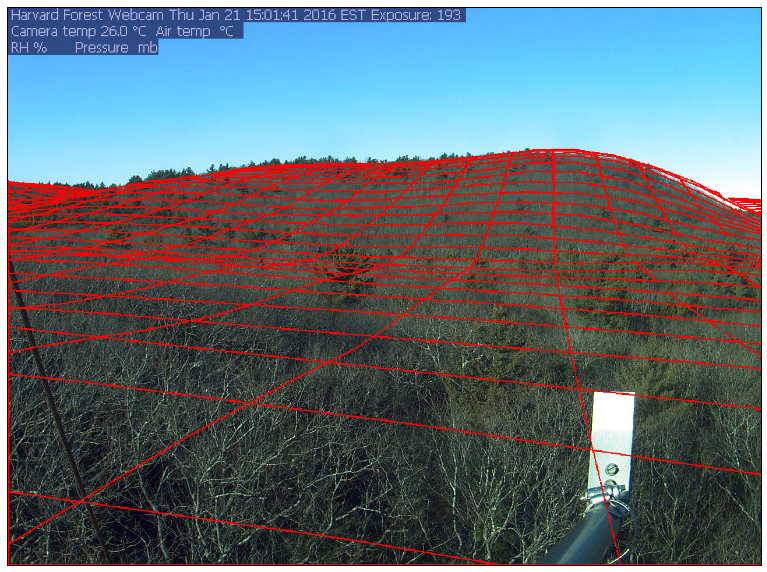

In [18]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
# local_fname = quickbird.get_local_image_fname(quickbird.midday_fnames[which_img])
# print local_fname
ax.imshow(superimposed)
phenocamomatic.plotting.format_photo_axes(ax)



## Now to crosswalk this to specific Landsat pixels

In [20]:
index_grid = skimage.io.imread(ls_grid_index_fname)
index_grid = trans.resize(index_grid, (sample_image.shape[0], sample_image.shape[1], 3), preserve_range=True, order=0)

index_grid = np.ma.masked_where(index_grid > 254, index_grid)

##### This grid was construncted such that the red channel contains an index to the landsat pixel row and the green channel contains an indexto the landsat pixel column

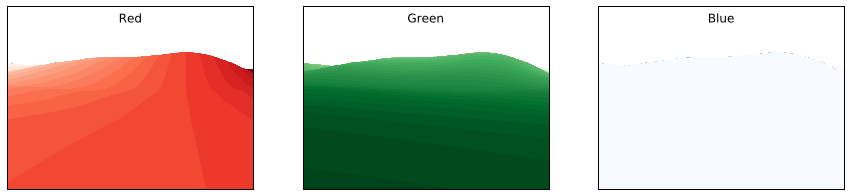

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

for index, cmap in enumerate([mpl.cm.Reds, mpl.cm.Greens, mpl.cm.Blues]):
    axes[index].imshow(index_grid[:,:,index], cmap=cmap)
    phenocamomatic.plotting.format_photo_axes(axes[index])
    phenocamomatic.plotting.add_inner_title(axes[index], cmap.name[:-1], 9)

    
#Note that the blue channel is not used

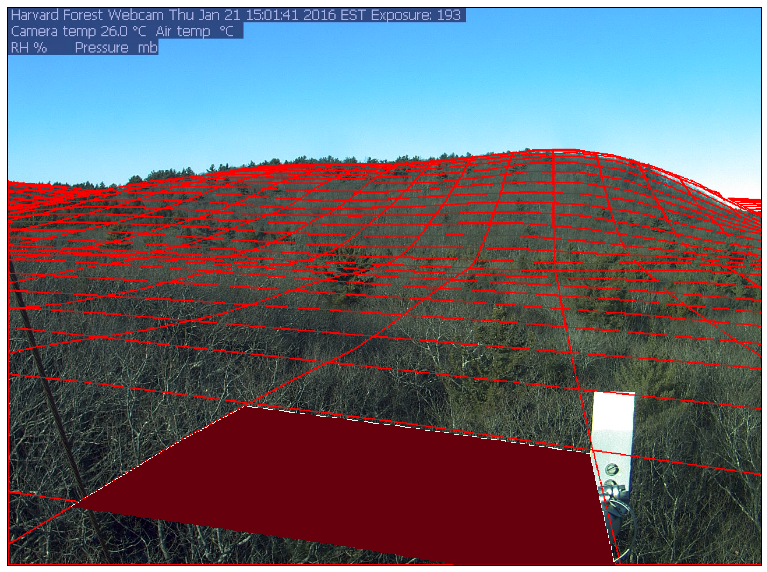

In [22]:
single_pixel = np.logical_and(index_grid[:,:,0]==127, index_grid[:,:,1]==249)

single_pixel = np.ma.asarray(trans.resize(single_pixel, 
            (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]

single_pixel.mask = single_pixel==False

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(superimposed)
ax.imshow(single_pixel, alpha = 1.0, cmap=mpl.cm.Reds, interpolation='none')
phenocamomatic.plotting.format_photo_axes(ax)

# But how do we get the actual coordinates of the pixel centroids instead of this rather arbitrary index?

In [23]:
x = 1
y = 1

landsat.affine *  (x, y)

(235755.0, 4721865.0)

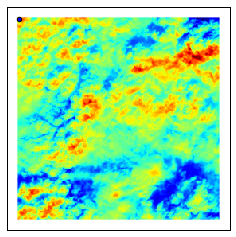

In [24]:
plt.imshow(landsat_data[0,:,:], interpolation='none')
phenocamomatic.plotting.format_photo_axes(plt.gca())
plt.scatter(*(x, y))

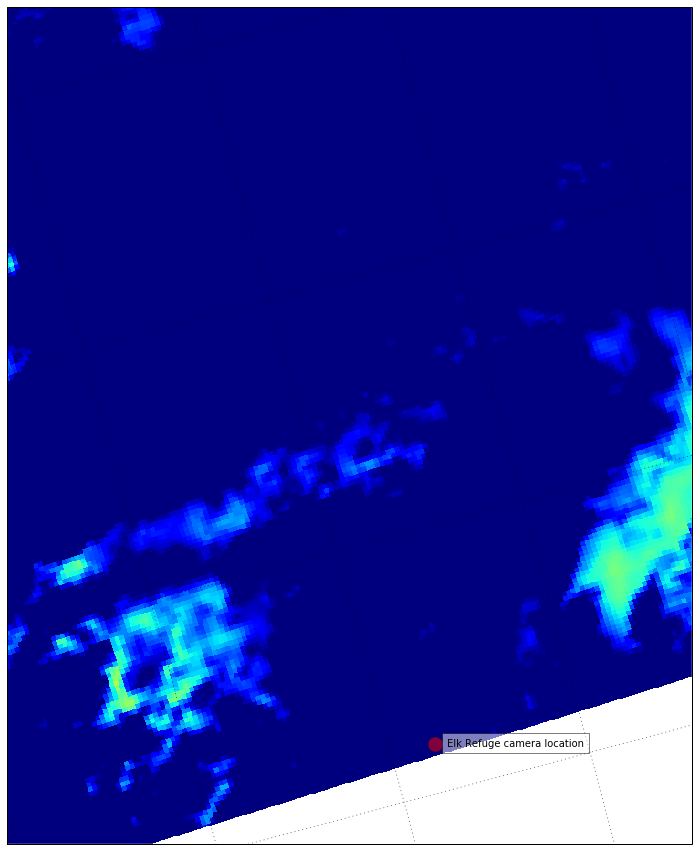

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ax_proj = ccrs.LambertConformal()
landsat_proj = ccrs.UTM(zone=int(landsat.crs_wkt.split("UTM zone ")[1].split('N')[0]), 
                         globe=ccrs.Globe(datum='WGS84',
                                              ellipse='WGS84'))
geodetic = ccrs.Geodetic()

fig = plt.figure(figsize=(15, 15))
ax_extent = [quickbird.x - 0.02, quickbird.x + 0.02, quickbird.y - 0.002, quickbird.y + 0.040]

img_extents = [landsat.bounds.left, landsat.bounds.right, landsat.bounds.bottom, landsat.bounds.top]

ax = plt.axes(projection=ax_proj)
ax.set_extent(ax_extent, ccrs.Geodetic())
ax.imshow(landsat_data[0, :, :], origin='upper', extent=img_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.jet_r, vmin=6968, vmax=29629)

# # ax.set_xmargin(0.05)
# # ax.set_ymargin(0.10)

# mark a known place to help us geo-locate ourselves
locx, locy = list(ax_proj.transform_point(quickbird.x, quickbird.y, geodetic))
ax.plot(locx, locy, 'bo', markersize=15, color='red', alpha=0.5)
ax.text(locx+75, locy-15, 'Elk Refuge camera location', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.BORDERS)
ax.gridlines()
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')


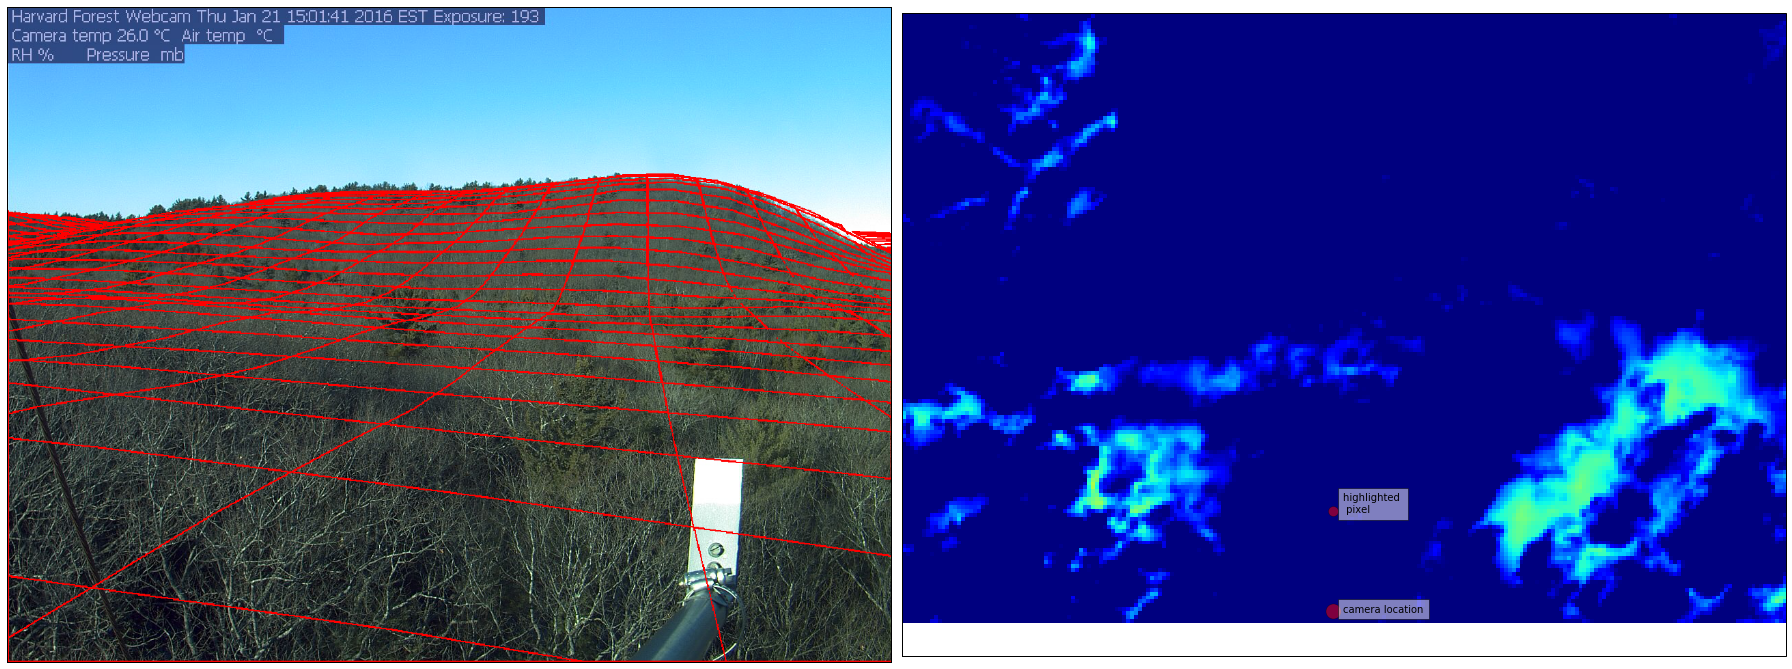

In [42]:
%matplotlib inline
from ipywidgets import interactive

col_index, row_index = 0,0
#col_index=127, row_index=250
def plot_one(col_index=127, row_index=249):
    single_pixel = np.logical_and(index_grid[:,:,0]==col_index, index_grid[:,:,1]==row_index)

    single_pixel = np.ma.asarray(trans.resize(single_pixel, 
                (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]

    single_pixel.mask = single_pixel==False

    fig = plt.figure(figsize=(25, 15))
    ax = plt.subplot(121)
    ax.imshow(superimposed)
    ax.imshow(single_pixel, alpha = 0.75, cmap=mpl.cm.Blues, interpolation='none')
    phenocamomatic.plotting.format_photo_axes(ax)

    ax_proj = landsat_proj
    ax2 = plt.subplot(122, projection=ax_proj)
    ax_extent = [quickbird.x - 0.04, quickbird.x + 0.04, quickbird.y - 0.002, quickbird.y + 0.040]
    ax2.set_extent(ax_extent, ccrs.Geodetic())
    ax2.imshow(landsat_data[0, :, :], origin='upper', extent=img_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.jet_r, vmin=6968, vmax=29629)
    colx, coly = landsat.affine * (col_index, row_index)
    colx += landsat.transform[1]/2.
    coly += landsat.transform[5]/2.
    
    colxgeo, colygeo = list(ax_proj.transform_point(colx, coly, landsat_proj))
    ax2.plot(colxgeo, colygeo, 'bo', markersize=10, color='red', alpha=0.5)
    ax2.text(colxgeo+75, colygeo-15, 'highlighted \n pixel', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    # mark a known place to help us geo-locate ourselves
    locx, locy = list(ax_proj.transform_point(quickbird.x, quickbird.y, geodetic))
    ax2.plot(locx, locy, 'bo', markersize=15, color='red', alpha=0.5)
    ax2.text(locx+75, locy-10, 'camera location', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    plt.tight_layout()
    
interactive(plot_one, col_index=(0, landsat.shape[0], 1), row_index=(0, landsat.shape[1], 1))

### let's map these landsat pixels onto our image

In [36]:
#this isn't terribly efficient but a good demonstration/validation of the technique 
mapped_output = np.zeros(np.squeeze(index_grid).shape)

new_shape = (reduce(lambda x, y: x*y, index_grid[:, :, :2].shape)/2, 2)
a = index_grid[:, :, :2].reshape(new_shape)

b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
_, idx = np.unique(b, return_index=True)

unique_a = a[idx]

done = 0
for col, row in unique_a.astype(np.uint8):
    print col, row,
    if col and row:
        single_pixel = np.logical_and(index_grid[:,:,0]==col_index, index_grid[:,:,1]==row_index)
        single_pixel = np.ma.asarray(trans.resize(single_pixel, 
                    (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]
        single_pixel.mask = single_pixel==False
        
        mapped_output[single_pixel==True] = landsat_data[0, row+1, col]
        done += 1
        print done, '\t',
    
mapped_output_masked = np.ma.masked_where(mapped_output==0, mapped_output)

37 74 1 	37 75 2 	37 75 3 	37 75 4 	37 76 5 	37 74 6 	37 74 7 	38 77 8 	38 78 9 	40 74 10 	40 77 11 	40 80 12 	40 75 13 	40 77 14 	40 75 15 	40 78 16 	40 75 17 	40 78 18 	40 76 19 	40 78 20 	40 76 21 	40 79 22 	40 76 23 	40 79 24 	40 77 25 	40 79 26 	41 77 27 	41 80 28 	41 77 29 	41 80 30 	41 75 31 	41 78 32 	41 80 33 	41 75 34 	41 78 35 	41 81 36 	41 76 37 	41 78 38 	41 81 39 	41 76 40 	41 79 41 	41 81 42 	41 76 43 	41 79 44 	41 82 45 	41 77 46 	41 79 47 	41 82 48 	42 77 49 	42 80 50 	42 82 51 	42 77 52 	42 80 53 	42 83 54 	42 75 55 	42 78 56 	42 80 57 	42 75 58 	42 78 59 	42 81 60 	42 76 61 	42 78 62 	42 81 63 	42 76 64 	42 79 65 	42 81 66 	42 76 67 	42 79 68 	42 82 69 	42 77 70 	42 79 71 	42 82 72 	45 69 73 	45 69 74 	45 70 75 	45 70 76 	45 70 77 	45 71 78 	45 68 79 	45 69 80 	43 77 81 	43 80 82 	43 77 83 	43 80 84 	43 78 85 	43 80 86 	43 75 87 	43 78 88 	43 81 89 	43 76 90 	43 78 91 	43 81 92 	43 76 93 	43 79 94 	43 81 95 	43 76 96 	43 79 97 	43 82 98 	43 77 99 	43 79 100 	45 69 10

#### While there's a little difference in how the colorramp is scaled 
we can verify that this output matches what we're seing in ArcScene

In [40]:
35000/75

466

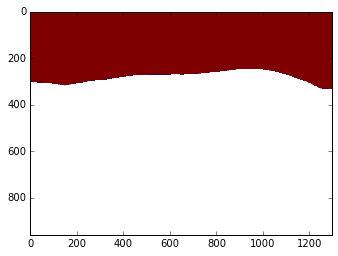

In [39]:
cp; 
plt.imshow(single_pixel)

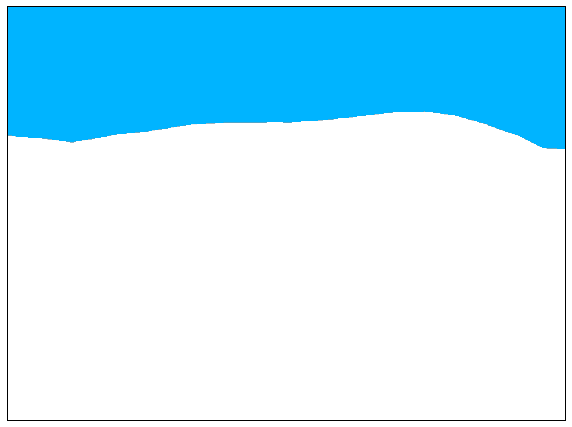

In [33]:
%matplotlib qt4
mapped_output_masked = np.ma.masked_where(mapped_output==0, mapped_output)
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(mapped_output_masked[:,:,0], cmap=mpl.cm.jet_r, vmin=15396, vmax=56938)
phenocamomatic.plotting.format_photo_axes(ax)

In [32]:
mapped_output

array([[[     0.,      0.,      0.],
        [     0.,      0.,      0.],
        [     0.,      0.,      0.],
        ..., 
        [     0.,      0.,      0.],
        [     0.,      0.,      0.],
        [     0.,      0.,      0.]],

       [[ 19580.,  19580.,  19580.],
        [ 19580.,  19580.,  19580.],
        [ 19580.,  19580.,  19580.],
        ..., 
        [ 19580.,  19580.,  19580.],
        [ 19580.,  19580.,  19580.],
        [ 19580.,  19580.,  19580.]],

       [[ 19580.,  19580.,  19580.],
        [ 19580.,  19580.,  19580.],
        [ 19580.,  19580.,  19580.],
        ..., 
        [ 19580.,  19580.,  19580.],
        [ 19580.,  19580.,  19580.],
        [ 19580.,  19580.,  19580.]],

       ..., 
       [[     0.,      0.,      0.],
        [     0.,      0.,      0.],
        [     0.,      0.,      0.],
        ..., 
        [ 19580.,  19580.,  19580.],
        [ 19580.,  19580.,  19580.],
        [ 19580.,  19580.,  19580.]],

       [[     0.,      0.,      0.]

In [184]:
%matplotlib qt4
from ipywidgets import interactive

col_index, row_index = 0,0

def plot_one(col_index=30, row_index=50):
    single_pixel = np.logical_and(index_grid[:,:,0]==col_index*3, index_grid[:,:,1]==row_index*3)
    single_pixel = np.ma.asarray(trans.resize(single_pixel, 
                (sample_image.shape[0], sample_image.shape[1], 3), preserve_range=False))[:,:,1]
    single_pixel.mask = single_pixel==False

    fig = plt.figure(figsize=(25, 15))
    ax = plt.subplot(121)
    ax.imshow(mapped_output_masked[:,:,0], cmap=mpl.cm.jet_r, vmin=9267, vmax=12233)
    ax.imshow(single_pixel, alpha = 1.0, cmap=mpl.cm.Reds_r, interpolation='none')
    phenocamomatic.plotting.format_photo_axes(ax)

    ax_proj = landsat_proj
    ax2 = plt.subplot(122, projection=ax_proj)
    ax2.set_extent(ax_extent, ccrs.Geodetic())
    ax2.imshow(landsat_data[0, :, :], origin='upper', extent=img_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.jet_r, vmin=9267, vmax=12233)
    colx, coly = landsat.affine * (col_index, row_index)
    colx += landsat.transform[1]/2.
    coly += landsat.transform[5]/2.
    
    colxgeo, colygeo = list(ax_proj.transform_point(colx, coly, landsat_proj))
    ax2.plot(colxgeo, colygeo, 'bo', markersize=10, color='red', alpha=0.5)
    ax2.text(colxgeo+75, colygeo-15, 'highlighted pixel', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    # mark a known place to help us geo-locate ourselves
    locx, locy = list(ax_proj.transform_point(quickbird.x, quickbird.y, geodetic))
    ax2.plot(locx, locy, 'bo', markersize=15, color='red', alpha=0.5)
    ax2.text(locx+75, locy-10, 'quickbird camera location', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    plt.tight_layout()
    
interactive(plot_one, col_index=(0, landsat.shape[0], 1), row_index=(0, landsat.shape[1], 1))

In [180]:
unique_a

masked_array(data =
 [[16.0 28.0]
 [16.0 27.0]
 [16.0 31.0]
 [16.0 30.0]
 [16.0 29.0]
 [18.0 28.0]
 [18.0 32.0]
 [18.0 36.0]
 [18.0 27.0]
 [18.0 31.0]
 [18.0 35.0]
 [18.0 30.0]
 [18.0 34.0]
 [18.0 29.0]
 [18.0 33.0]
 [20.0 28.0]
 [20.0 32.0]
 [20.0 27.0]
 [20.0 31.0]
 [20.0 35.0]
 [20.0 30.0]
 [20.0 34.0]
 [20.0 29.0]
 [20.0 33.0]
 [24.0 16.0]
 [24.0 24.0]
 [24.0 28.0]
 [24.0 32.0]
 [24.0 48.0]
 [24.0 43.0]
 [24.0 27.0]
 [24.0 31.0]
 [24.0 46.0]
 [24.0 17.0]
 [24.0 26.0]
 [24.0 30.0]
 [24.0 34.0]
 [24.0 42.0]
 [24.0 44.0]
 [24.0 47.0]
 [24.0 25.0]
 [24.0 29.0]
 [24.0 33.0]
 [24.0 45.0]
 [28.0 18.0]
 [28.0 24.0]
 [28.0 28.0]
 [28.0 48.0]
 [28.0 56.0]
 [28.0 51.0]
 [28.0 23.0]
 [28.0 27.0]
 [28.0 49.0]
 [28.0 17.0]
 [28.0 19.0]
 [28.0 21.0]
 [28.0 22.0]
 [28.0 26.0]
 [28.0 52.0]
 [28.0 47.0]
 [28.0 55.0]
 [28.0 25.0]
 [28.0 50.0]
 [32.0 18.0]
 [32.0 20.0]
 [32.0 24.0]
 [32.0 23.0]
 [32.0 49.0]
 [32.0 17.0]
 [32.0 19.0]
 [32.0 21.0]
 [32.0 22.0]
 [32.0 25.0]
 [32.0 50.0]
 [36.0 14.0]
 [36